In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2
import json

In [48]:
%%capture captured
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))

In [49]:
train_path='/home/kabilan/Desktop/caption/sample/image_caption_test_dict.json'

In [50]:
train_captions = json.load(open(train_path,'r'))

In [51]:
path = "../dataset/images/"

In [52]:
for each in train_captions.keys():
    captions = train_captions[each]
    for i in range(len(captions)):
        captions[i] =  "<start> " + f"{captions[i]}".strip() + " <end>"

In [53]:
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

100%|████████████████████████████████████████████████████████████████| 1000/1000 [01:18<00:00, 12.79it/s]


In [54]:
all_captions=[]
for img_id in train_captions:
  for captions in train_captions[img_id]:
    all_captions.append(captions)
all_words=" ".join(all_captions)
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

332863
2648


In [55]:
vocab_size=len(unique_words)+1
max_length=40

In [56]:
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

In [57]:
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 22438.55it/s]


In [58]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 25377.57it/s]


In [59]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in train_encoded_captions:
    n+=1
    for i in range(5):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield [[array(X1), array(X2)], array(Y)]
      X1, X2, Y = list(), list(), list()
      n=0

In [60]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import  LSTM
from keras.layers.merge import add
from keras.layers.embeddings import Embedding
import keras

In [61]:
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 256)      678144      input_18[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_17[0][0]                   
____________________________________________________________________________________________

In [62]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
epochs=10
no_of_photos=1
steps=len(train_encoded_captions)
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

In [63]:
model.save('model_40.h5')

In [64]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  return final

../dataset/images/3385593926_d3e9c21170.jpg


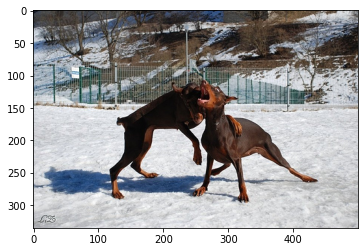

['catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic']
../dataset/images/2677656448_6b7e7702af.jpg


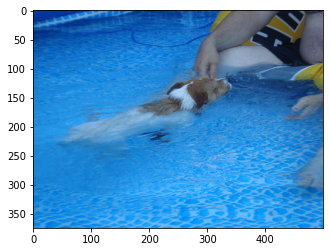

['African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African', 'African']
../dataset/images/311146855_0b65fdb169.jpg


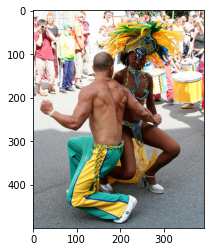

['single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single']
../dataset/images/1258913059_07c613f7ff.jpg


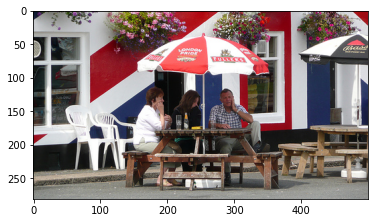

['focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus']
../dataset/images/241347760_d44c8d3a01.jpg


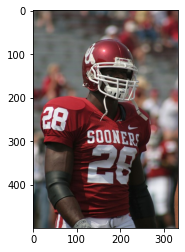

['paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler']
../dataset/images/2654514044_a70a6e2c21.jpg


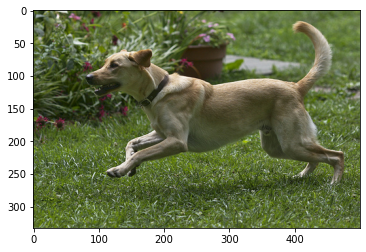

['thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing']
../dataset/images/2339106348_2df90aa6a9.jpg


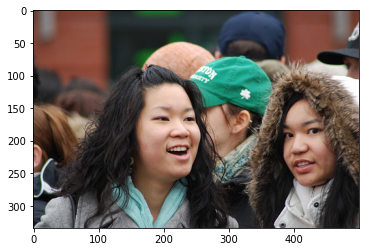

['paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler', 'paddler']
../dataset/images/256085101_2c2617c5d0.jpg


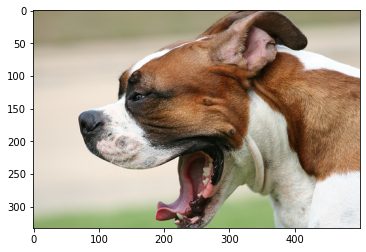

['spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate', 'spectate']
../dataset/images/280706862_14c30d734a.jpg


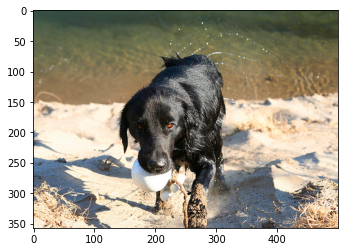

['collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate']
../dataset/images/3072172967_630e9c69d0.jpg


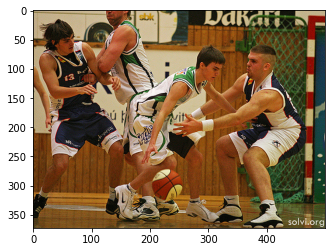

['thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing']
../dataset/images/3482062809_3b694322c4.jpg


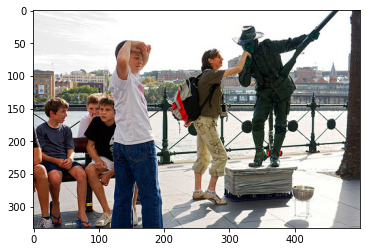

['rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby', 'rugby']
../dataset/images/1167669558_87a8a467d6.jpg


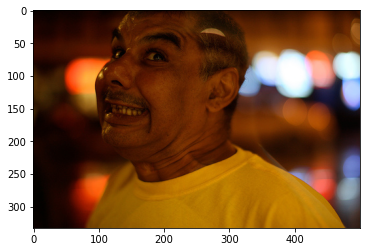

['sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless']
../dataset/images/2847615962_c330bded6e.jpg


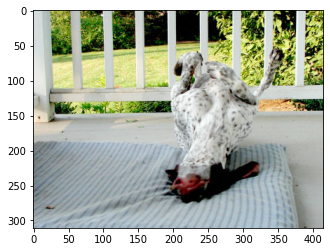

['thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing', 'thing']
../dataset/images/3344233740_c010378da7.jpg


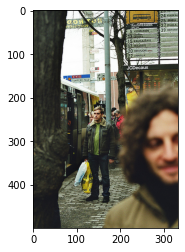

['sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless', 'sleeveless']
../dataset/images/2435685480_a79d42e564.jpg


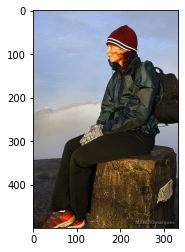

['single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single', 'single']
../dataset/images/3110649716_c17e14670e.jpg


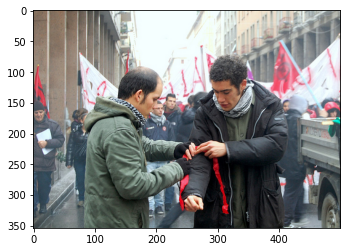

['catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic', 'catholic']
../dataset/images/2511019188_ca71775f2d.jpg


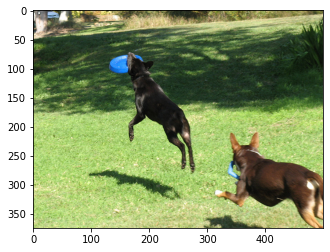

['collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate', 'collaborate']
../dataset/images/2521770311_3086ca90de.jpg


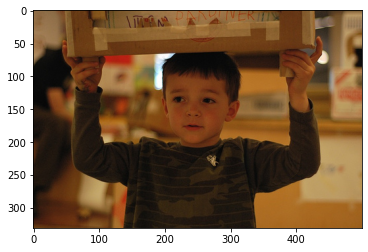

['backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard']
../dataset/images/2723477522_d89f5ac62b.jpg


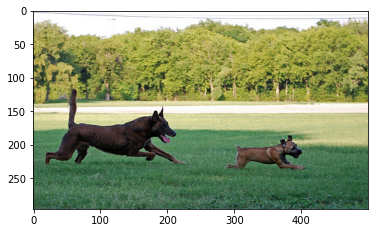

['follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow', 'follow']
../dataset/images/2218609886_892dcd6915.jpg


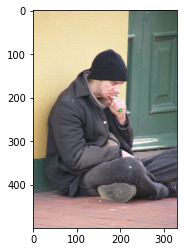

['backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard', 'backyard']


In [66]:
for img_id in list(train_features.keys())[0:20]:
    img=cv2.imread(path+img_id)
    print(path+img_id)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));
    photo=train_features[img_id]
    candidate=greedy_search(photo)
    plt.show()
    print(candidate)

In [ ]:
words_to_indices

In [39]:
model_0 = keras.models.load_model('model_40.h5')

In [21]:
with open("words_to_indices.json", "w") as outfile:
    json.dump(words_to_indices, outfile)


In [22]:
with open("indices_to_words.json", "w") as outfile:
    json.dump(indices_to_words, outfile)

In [40]:
class CaptionService():
    def __init__(self):
        self.model = keras.models.load_model('model_40.h5')
        self.max_length = 40
        self.res_model = ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
        self.words_to_indices = json.load(open("words_to_indices.json",'r'))
        self.indices_to_words = json.load(open("indices_to_words.json",'r'))
        
    def get_caption(self,image_path):
        photo = self.get_features(image_path)
        caption = self.greedy_search(photo)
        return " ".join(caption)
    
        
    def get_features(self,image_path):
        img = image.load_img(image_path,target_size=(224,224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features = self.res_model.predict(x)
        return features.squeeze()
    
    def greedy_search(self,photo):
        photo=photo.reshape(1,2048)
        in_text='<start>'
        for i in range(self.max_length):
            sequence = [self.words_to_indices[s] for s in in_text.split(" ") if s in self.words_to_indices]
            sequence = pad_sequences([sequence], maxlen=self.max_length, padding='post')
            y_pred = self.model.predict([photo,sequence],verbose=0)
            y_pred = np.argmax(y_pred[0])
            word = self.indices_to_words[str(y_pred)]
            in_text += ' ' + word
            if word == '<end>':
                break
        final = in_text.split()
        final = final[1:-1]
        return final

In [41]:
CaptionService().get_caption('../dataset/images/3385593926_d3e9c21170.jpg')

'ride pharmacy Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk'

In [42]:
cs = CaptionService()

In [46]:
for img_id in list(train_features.keys())[0:20]:
    print(cs.get_caption(path+img_id))
    plt.show()

ride pharmacy Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk
ride pharmacy Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk
ride pharmacy Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk
ride pharmacy Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk
ride pharmacy Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk
ride pharmacy Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk Unk
pharmacy Unk Unk Unk Unk Unk